In [2]:
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

c:\Users\clara\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Maping each sport name to an id and saving it in a dictionary for easy use throughout the code.

In [3]:
labels = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'cricket',
    5: 'football',
    6: 'gymnastics',
    7: 'hockey',
    8: 'swimming',
    9: 'table_tennis',
    10: 'tennis',
    11: 'volleyball',
    12: 'weight_lifting',
    13: 'wrestling',
    14: 'wwe'
}


def get_key(val):
    for key, value in labels.items():
        if val == value:
            return key
 
    return False

In [4]:
def build_csv(labels):
    directory=".\data\images"
    data=[]
    for root, subdirectories, files in os.walk(directory):
        if any(map(lambda p: p[0] == '.', subdirectories)):
            continue
        for subdirectory in subdirectories:
            label=get_key(subdirectory)
            for r, s, files in os.walk(os.path.join(root, subdirectory)):
                for f in files:
                    data.append([os.path.join(root, subdirectory,f),label])
                    

    df= pd.DataFrame(data, columns=['path', 'label'])

    df.to_csv("./data/data.csv", index=False)


build_csv(labels)

In [5]:
df = pd.read_csv("./data/data.csv")
df.head(5)

,path,label
0,.\data\images\badminton\00000000.jpg,0
1,.\data\images\badminton\00000001.jpg,0
2,.\data\images\badminton\00000002.png,0
3,.\data\images\badminton\00000003.jpg,0
4,.\data\images\badminton\00000004.jpg,0


In [6]:
len(df['label'].unique())

15

<function matplotlib.pyplot.axes(arg=None, **kwargs)>

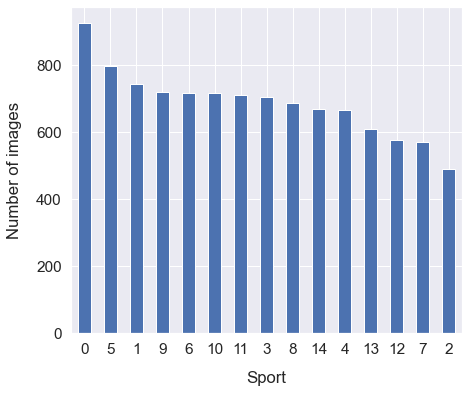

In [7]:
sns.set(font_scale=1.4)
df['label'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Number of images", labelpad=14)
plt.xlabel("Sport", labelpad=14)
plt.axes

In [8]:
class SportsImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['path'], row['label']
        img_fname = img_id
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, int(img_label)

In [9]:
np.random.RandomState(42)

RandomState(MT19937) at 0x283BB6EAC40

In [10]:
train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

len(train_df), len(val_df), len(test_df)

(8261, 1033, 1033)

In [11]:
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [12]:
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_tfms = transforms.Compose(
    [
        transforms.Resize((72,72)),
        transforms.RandomCrop(64, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.RandomErasing(inplace=False), 
        transforms.Normalize(*stats,inplace=True)
    ]
)

valid_tfms = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.ToTensor(), 
        transforms.Normalize(*stats)
    ]
)

In [13]:
train_ds = SportsImageDataset(train_df, "./data/images", transform=train_tfms)
val_ds = SportsImageDataset(val_df, "./data/images/", transform=valid_tfms)
test_ds = SportsImageDataset(test_df, "./data/images/", transform=valid_tfms)

In [14]:
def show_sample(img, target, prediction= False, invert=True):
    print(img.shape)
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Label (numeric):', target)
    if not prediction:
        print('Label:', labels[target])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
Label (numeric): 0
Label: badminton


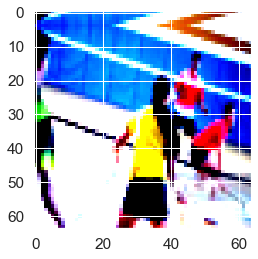

In [15]:
show_sample(*train_ds[11] ,invert=False)

In [16]:
torch.manual_seed(42)

In [17]:
batch_size = 32

In [18]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)